In [171]:
!pip install numpy matplotlib pyyaml scipy

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import yaml
import os

In [173]:
def get_params(config):
    try:
        # Acessa as configurações aninhadas
        ds = config['DATASET']
        rf = config['RF_FRONT_END']
        gps = config['GPS_STANDARD']
        acq = config['ACQUISITION']

        # 1. Extração de Variáveis Base (Conversão de Tipo)
        
        FILENAME = ds['FILENAME']
        # Converte a string 'int8' para o tipo numpy.int8
        DATA_DTYPE = getattr(np, ds['DTYPE']) 
        PRN_ID_TO_SEARCH = ds['PRN_ID_TO_SEARCH']
        
        FS = rf['FS']
        FIF = rf['FIF']
        
        PRN_CHIP_RATE = gps['PRN_CHIP_RATE']
        PRN_LENGTH = gps['PRN_LENGTH']
        
        DOPPLER_RANGE = acq['DOPPLER_RANGE']
        DOPPLER_STEP = acq['DOPPLER_STEP']
        TIME_TO_PROCESS = acq['TIME_TO_PROCESS']

        # 2. Cálculo de Parâmetros Derivados
        
        # Amostras por Chip (define o superamostramento da réplica do código)
        SAMPLES_PER_CHIP = round(FS / PRN_CHIP_RATE)
        
        # Amostras em um Período de Código (aprox.)
        SAMPLES_PER_CODE = PRN_LENGTH * SAMPLES_PER_CHIP
        
        # Número de Amostras para Integração Coerente (idealmente 1ms ou múltiplo)
        N_SAMPLES_COHERENT = int(FS * TIME_TO_PROCESS)
        
        # Garante que o bloco de amostras seja um múltiplo exato do período do código,
        # essencial para a correlação cíclica (FFT).
        N_SAMPLES_COHERENT = (N_SAMPLES_COHERENT // SAMPLES_PER_CODE) * SAMPLES_PER_CODE
        
        # 3. Retorno das Constantes
        return {
            'FILENAME': FILENAME, 
            'DTYPE': DATA_DTYPE, 
            'PRN_ID_TO_SEARCH': PRN_ID_TO_SEARCH,
            'FS': FS, 
            'FIF': FIF, 
            'PRN_CHIP_RATE': PRN_CHIP_RATE, 
            'PRN_LENGTH': PRN_LENGTH,
            'DOPPLER_RANGE': DOPPLER_RANGE, 
            'DOPPLER_STEP': DOPPLER_STEP,
            'TIME_TO_PROCESS': TIME_TO_PROCESS,
            'SAMPLES_PER_CHIP': SAMPLES_PER_CHIP,
            'SAMPLES_PER_CODE': SAMPLES_PER_CODE,
            'N_SAMPLES_COHERENT': N_SAMPLES_COHERENT
        }
    
    except KeyError as e:
        # Captura erros se uma chave essencial não estiver no arquivo de configuração
        raise KeyError(f"Erro: Chave de configuração ausente ou incorreta: {e}")
    except Exception as e:
        # Captura erros gerais, como falha na conversão de tipo (ex: 'FS' não é um número)
        raise Exception(f"Erro ao processar constantes: {e}")

def load_config(config_file):
    try:
        with open(config_file, 'r') as f:
            # Usa safe_load para evitar a execução de código arbitrário
            config = yaml.safe_load(f)
        return config
    except FileNotFoundError:
        raise FileNotFoundError(f"Erro: Arquivo de configuração '{config_file}' não encontrado.")
    except yaml.YAMLError as e:
        raise ValueError(f"Erro ao decodificar YAML: {e}")

CONFIG_CLEAN_PATH = os.path.join("config", "fgi", "config_clean.yaml")
CONFIG_DS2_PATH = os.path.join("config", "fgi", "config_spoofed.yaml")

config_clean_data = load_config(CONFIG_CLEAN_PATH)
config_ds2_data = load_config(CONFIG_DS2_PATH)

PARAMS_CLEAN = get_params(config_clean_data)
PARAMS_DS2 = get_params(config_ds2_data)

print(f"Amostras por chip (CLEAN): {PARAMS_CLEAN['SAMPLES_PER_CHIP']}")
print(f"Amostras por chip (DS2): {PARAMS_DS2['SAMPLES_PER_CHIP']}")

Amostras por chip (CLEAN): 25
Amostras por chip (DS2): 25


In [174]:
# --- 1. Mapeamento dos Taps G2 (Baseado no seu código) ---
# O índice da linha corresponde ao PRN ID (1 a 37).
# Os valores nos vetores são os estágios do G2 que são combinados com G1.
PRN_G2_TAPS = [
    [2, 6], [3, 7], [4, 8], [5, 9], [1, 9], [2, 10], [1, 8], [2, 9], 
    [3, 10], [2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], 
    [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [1, 3], [4, 6], 
    [5, 7], [6, 8], [7, 9], [8, 10], [1, 6], [2, 7], [3, 8], [4, 9], 
    [5, 10], [4, 10], [1, 7], [2, 8], [4, 10]
]

def generate_ca_code(prn_id, samples_per_chip, code_length=1023):
    """
    Gera a sequência real do código C/A (G1 XOR G2) baseada na lógica de LFSR.
    
    Args:
        prn_id (int): ID do satélite (1 a 37).
        samples_per_chip (int): Fator de superamostragem.
        code_length (int): Deve ser 1023.
        
    Returns:
        np.ndarray: Réplica do código C/A com superamostragem (+1 e -1).
    """
    
    # Índice 0 é para PRN 1; devemos subtrair 1
    sv_index = prn_id - 1 

    if prn_id < 1 or prn_id > len(PRN_G2_TAPS):
        raise ValueError("PRN ID inválido (fora do intervalo 1-37).")

    # Inicialização: G1 e G2 com todos os 1s (usando 0/1 para lógica binária)
    LFSR_LEN = 10
    g1 = np.ones(LFSR_LEN, dtype=int) 
    g2 = np.ones(LFSR_LEN, dtype=int)
    
    ca_code_chips = np.zeros(code_length, dtype=int)
    
    # Taps G2 específicas do satélite (posições de 1 a 10)
    g2_taps = PRN_G2_TAPS[sv_index] 

    for i in range(code_length):
        
        # 1. Chips de Saída (Output Chips)
        
        # O G1 do GPS L1 C/A é sempre o estágio 10 (Índice 9 em 0-based)
        out_g1 = g1[9] 
        
        # O G2 é o XOR das conexões específicas do PRN (Índice = tap - 1)
        out_g2 = g2[g2_taps[0] - 1] ^ g2[g2_taps[1] - 1] 

        # 2. Combinação Final (O Código C/A)
        # O código C/A é o XOR de G1 e G2
        ca_chip_binary = out_g1 ^ out_g2
        ca_code_chips[i] = ca_chip_binary

        # 3. Deslocamento e Retroalimentação (Feedback)
        
        # Feedback G1: XOR dos estágios 3 e 10 (Índices 2 e 9)
        feedback_g1 = g1[2] ^ g1[9]
        
        # Feedback G2: XOR dos estágios 2, 3, 6, 8, 9 e 10 (Índices 1, 2, 5, 7, 8, 9)
        feedback_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]
        
        # Deslocamento (Shifting): O novo feedback entra no estágio 1 (Índice 0)
        # np.roll move os elementos, e o novo feedback entra na primeira posição
        g1 = np.roll(g1, 1)
        g1[0] = feedback_g1
        
        g2 = np.roll(g2, 1)
        g2[0] = feedback_g2
    
    # Conversão de chips binários (0, 1) para bipolares (-1, +1)
    bipolar_code_chips = 2 * ca_code_chips - 1
    
    # Superamostragem (Oversampling)
    code_replica = np.repeat(bipolar_code_chips, samples_per_chip)
    
    return code_replica

In [175]:
def correlate_signals(band_base_signal, local_code_replica):
    # 1. Transformar o sinal e a réplica do código
    fft_signal = np.fft.fft(band_base_signal)
    fft_code_replica = np.fft.fft(local_code_replica)
    
    # 2. Multiplicação no domínio da frequência (Correlação)
    fft_product = fft_signal * np.conjugate(fft_code_replica)
    
    # 3. IFFT e Magnitude
    correlation_result = np.fft.ifft(fft_product)
    
    return np.abs(correlation_result)

def desmodulate(gps_complex, N_samples, Fs, Fif_local):
    """
    Move o sinal para banda base usando a frequência local Fif_local.
    """
    t = np.arange(N_samples) / Fs
    local_carrier = np.exp(-1j * 2 * np.pi * Fif_local * t)
    return gps_complex * local_carrier

In [176]:
def plot_fourier_spectra(band_base_signal, local_code_replica, Fs):
    """
    Calcula e plota o espectro de magnitude (FFT) do sinal em banda base 
    e da réplica do código PRN.
    """
    N = len(band_base_signal)
    
    # 1. Cálculo da FFT
    # A FFT do código PRN deve ser conjugada no domínio da frequência para a correlação, 
    # mas para a plotagem do espectro, usamos a magnitude simples.
    fft_signal = np.fft.fft(band_base_signal)
    fft_code = np.fft.fft(local_code_replica)
    
    # 2. Deslocamento de Frequência (FFT-shift)
    # Move a frequência zero (DC) para o centro do espectro.
    fft_signal_shifted = np.fft.fftshift(fft_signal)
    fft_code_shifted = np.fft.fftshift(fft_code)
    
    # 3. Cálculo da Potência (Magnitude ao Quadrado ou apenas Magnitude em dB)
    # Usamos o logaritmo da magnitude (em dB) para visualizar melhor a faixa dinâmica.
    spectrum_signal = 10 * np.log10(np.abs(fft_signal_shifted) + 1e-10) # +1e-10 para evitar log(0)
    spectrum_code = 10 * np.log10(np.abs(fft_code_shifted) + 1e-10)
    
    # 4. Geração do Eixo de Frequência
    # O eixo de frequência vai de -Fs/2 até +Fs/2
    freq_axis = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))
    
    plt.figure(figsize=(12, 6))
    
    # Plotagem do Espectro do Código PRN
    plt.plot(freq_axis / 1e6, spectrum_code, color='orange', label='Espectro da Réplica do Código PRN')
    
    # Plotagem do Espectro do Sinal em Banda Base (com Ruído)
    plt.plot(freq_axis / 1e6, spectrum_signal, color='blue', label='Espectro do Sinal GNSS em Banda Base')
    
    plt.title('Espectro de Frequência dos Sinais (Domínio de Frequência)')
    plt.xlabel('Frequência (MHz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [177]:
# LPF no sinal em banda base
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [178]:
def acquire_gnss_signal(filepath):

    filename = os.path.basename(filepath)

    if "clean" in filename:
        cfg = PARAMS_CLEAN
    elif "TGS" in filename:
        cfg = PARAMS_DS2

    # --- 1. Leitura e Preparação do Sinal ---
    try:

        required_real_elements = cfg["N_SAMPLES_COHERENT"] * 2

        # Lendo os dados como Int8 e convertendo para complexo
        raw_data = np.fromfile(filepath, dtype=cfg["DTYPE"], count=required_real_elements)
        
        # Intercalação: I = [0, 2, 4...], Q = [1, 3, 5...]
        I_samples = raw_data.astype(np.float32)
        # Q_samples =  raw_data[1::2].astype(np.float32)
        
        gps_complex = I_samples #+ 1j * Q_samples
        N_total = len(gps_complex)

        fs = 1000  # Sample frequency (Hz)
        cutoff = 40.0  # Cutoff frequency (Hz)
        order = 6    # Filter order

        # Apply the low-pass filter
        gps_complex = butter_lowpass_filter(gps_complex, cutoff, fs, order)
        
        # Usaremos apenas um bloco coerente
        gps_segment = gps_complex[:cfg["N_SAMPLES_COHERENT"]]
        N_segment = len(gps_segment)

        if len(raw_data) < required_real_elements:
                n_samples = cfg["N_SAMPLES_COHERENT"]
                print(f"Erro: Arquivo muito curto. Lido {len(raw_data)//2} amostras complexas.")
                print(f"Necessário {n_samples} amostras complexas para {cfg['TIME_TO_PROCESS'] * 1000:.1f} ms.")
                return
        
        print(f"\nSinal lido e segmentado: {N_segment} amostras.")
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado.")
        return

    # --- 2. Geração da Réplica do Código Local ---
    # Geramos apenas o código para o PRN ID de busca
    local_code_chips = generate_ca_code(cfg["PRN_ID_TO_SEARCH"], cfg["SAMPLES_PER_CHIP"], cfg["PRN_LENGTH"])
    # O código local deve ter o mesmo comprimento que o segmento de sinal
    local_code_replica = np.tile(local_code_chips, N_segment // cfg["SAMPLES_PER_CODE"])

    # --- 3. Busca Bidimensional (2D) ---
    max_correlation_value = 0.0
    best_doppler = 0.0
    best_tau = 0
    
    # Define a faixa de frequências a testar
    doppler_freqs = np.arange(-cfg["DOPPLER_RANGE"], cfg["DOPPLER_RANGE"] + cfg["DOPPLER_STEP"], cfg["DOPPLER_STEP"])
    
    prn_id_to_search = cfg["PRN_ID_TO_SEARCH"]
    print(f"Iniciando busca para PRN {prn_id_to_search}...")

    for doppler in doppler_freqs:
        # A frequência local de desmodulação varia o Doppler
        Fif_local = cfg["FIF"] + doppler
        
        # Desmodula o sinal para banda base (remove Fif e o Doppler de teste)
        band_base_signal = desmodulate(gps_segment, N_segment, cfg["FS"], Fif_local)
        
        # Correlação com o código PRN local (Busca no atraso tau)
        correlation_magnitude = correlate_signals(band_base_signal, local_code_replica)
        
        # Encontra o pico de correlação nesta frequência Doppler
        current_max = np.max(correlation_magnitude)
        
        if current_max > max_correlation_value:
            max_correlation_value = current_max
            best_doppler = doppler
            # O índice do pico é o atraso de código (tau)
            best_tau = np.argmax(correlation_magnitude)
            
    # --- 4. Resultados e Plotagem ---
    
    print("\n--- Resultado da Aquisição ---")
    print(f"PRN Adquirido: {prn_id_to_search}")
    print(f"Doppler Encontrado (Freq.): {best_doppler:.1f} Hz")
    
    # O atraso $\tau$ é o índice de amostra. Convertendo para chips:
    tau_chips = best_tau / cfg["SAMPLES_PER_CHIP"]
    print(f"Atraso de Código Encontrado ($\\tau$): {tau_chips:.2f} chips")
    print(f"Valor do Pico de Correlação: {max_correlation_value:.2f}")

    # Plotagem (Re-correlaciona no melhor ponto para plotar)
    final_fif_local = cfg["FIF"] + best_doppler
    final_band_base = desmodulate(gps_segment, N_segment, cfg["FS"], final_fif_local)
    final_correlation = correlate_signals(final_band_base, local_code_replica)
    
    tau_axis = np.arange(len(final_correlation)) / cfg["SAMPLES_PER_CHIP"]
    
    plt.figure(figsize=(10, 5))
    plt.plot(tau_axis, final_correlation, color='green')
    plt.scatter(tau_chips, max_correlation_value, color='red', s=100, zorder=5, 
                label=f'Pico ($\\tau={tau_chips:.2f}$ chips)')
    
    plt.title(f'Pico de Correlação (PRN {cfg["PRN_ID_TO_SEARCH"]}) em {best_doppler:.1f} Hz')
    plt.xlabel('Atraso de Código ($\tau$) em Chips')
    plt.ylabel('Magnitude da Correlação')
    plt.xlim(0, cfg["PRN_LENGTH"]) # Limita a visualização a 1023 chips
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 4. PLOTAGEM DO ESPECTRO DE FOURIER (ADICIONAL) ---
    print("\nPlotando Espectros de Frequência...")
    plot_fourier_spectra(final_band_base, local_code_replica, cfg["FS"])


Sinal lido e segmentado: 25575 amostras.
Iniciando busca para PRN 12...

--- Resultado da Aquisição ---
PRN Adquirido: 12
Doppler Encontrado (Freq.): 1500.0 Hz
Atraso de Código Encontrado ($\tau$): 398.60 chips
Valor do Pico de Correlação: 19.09


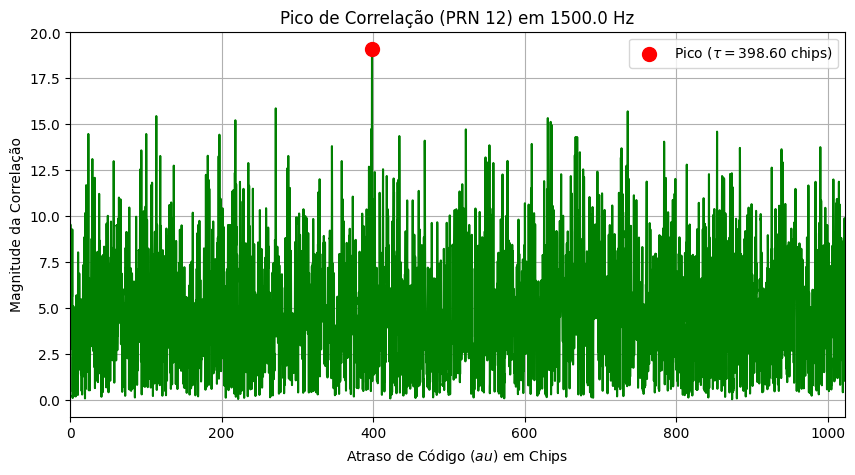


Plotando Espectros de Frequência...


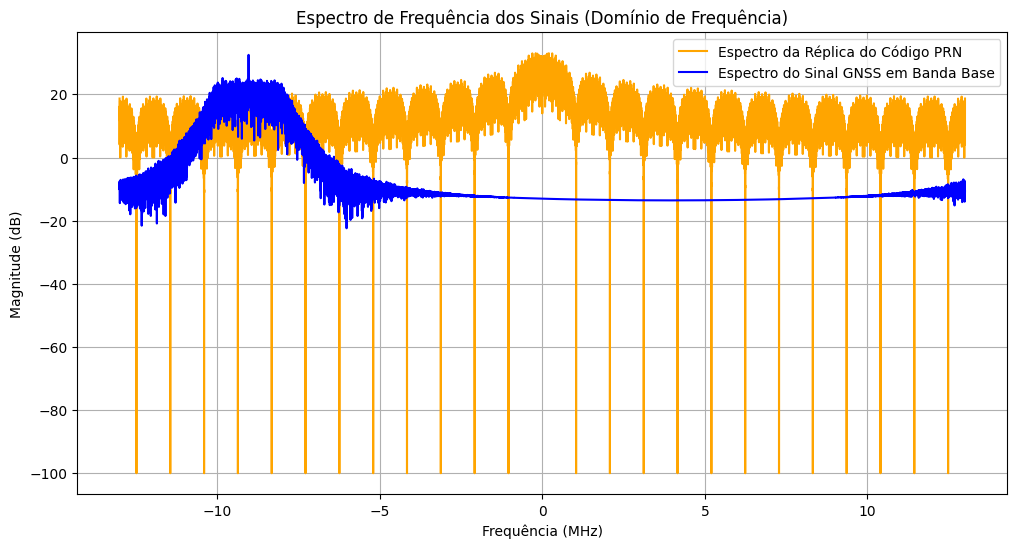


Sinal lido e segmentado: 25575 amostras.
Iniciando busca para PRN 17...

--- Resultado da Aquisição ---
PRN Adquirido: 17
Doppler Encontrado (Freq.): -5500.0 Hz
Atraso de Código Encontrado ($\tau$): 1016.40 chips
Valor do Pico de Correlação: 19.27


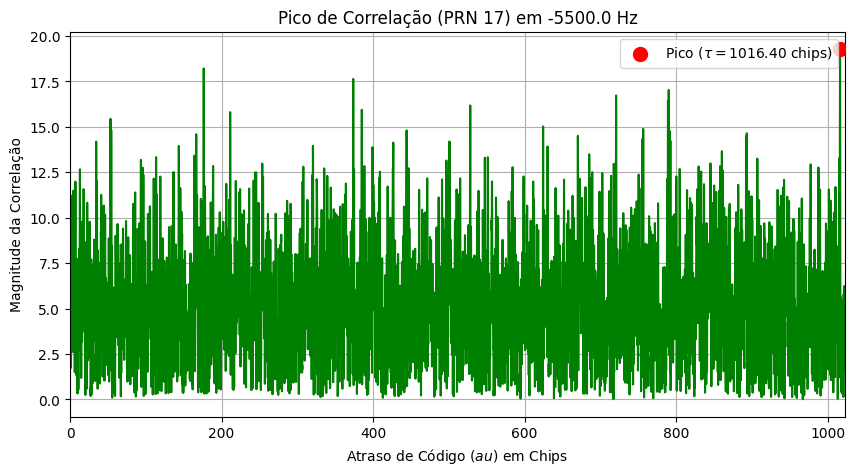


Plotando Espectros de Frequência...


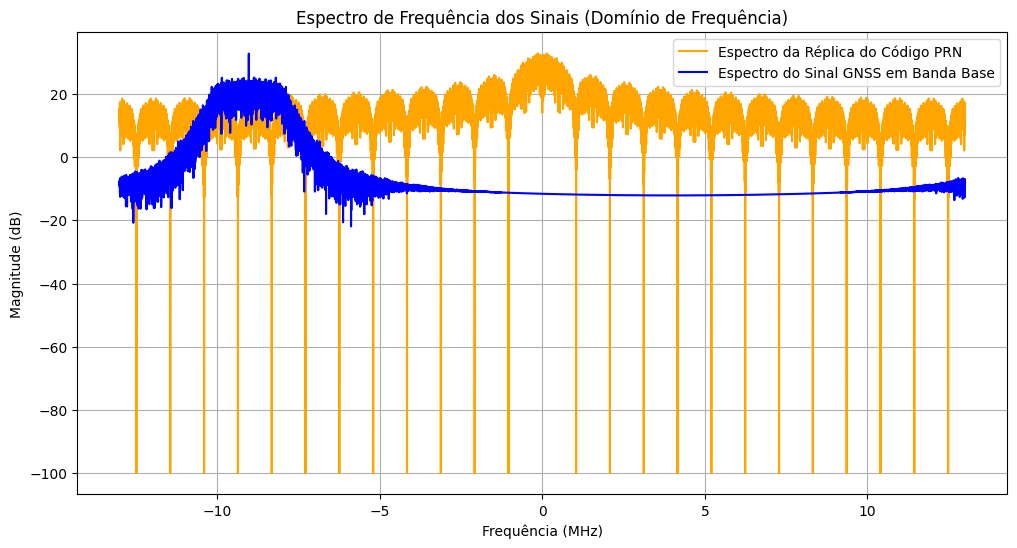

In [179]:
FILENAME_CLEAN = '/home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat'
FILENAME_SPOOFED = '/home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat'

# 2. Executar o processo de aquisição (busca 2D)
acquire_gnss_signal(FILENAME_CLEAN)
acquire_gnss_signal(FILENAME_SPOOFED)